# Machine Learning Lab

This project aims at comparing the efficiency of Convolutional Neural Networks (CNN) with respect to Random Forest (RF) algorithms for the classification of data in the MNIST-fashion dataset.

### Summary
The results of the project are delivered in this Jupyter Notebook as code cells that run the algorithms and markdown cells in order to provide comments. Both algorithms are imported from `classifiers.py` where the user can find the code.

In [1]:
from classifiers import CNN, RandomForest

 Both algorithms will follow this workflow:
 
1. load dataset
2. partition the dataset into a training and a test subsets
3. create a model (NN or forest)
4. train the model with the training subset
5. evaluate performances through the test subset

It is quite natural to implement the algorithms as subclasses that inherit most of their methods from a common parent class. In `classifiers.py` the user will find both the parent abstract class and the two sons. Since the user's primary goal is point 5, there is no need to call methods 1 to 4 in this Notebook: the code is structured such that a method called `evaluate` will return every goodness-of-fit indicator and run points 1 to 4 itself with help from che class constructor and a data-loading class in `data_loader.py`.

## Convolutional Network

### Architecture
The CNN is built as follows:

1. `Conv2D(kernel_size=5)`
    - `MaxPooling2D`
    - `Dropout`
1. `Conv2D(kernel_size=3)`
    - `MaxPooling2D`
    - `Dropout`
3. `Flatten`
4. `Dense`

Both convolutional layers have `relu` as activation function: this is quite common when dealing with CNNs. The final dense layer has `softmax`. The loss function is categorical cross-entropy: this is also common for CNNs.
Every other parameter of the network has to be stated by the user in a dictionary as input when the object is created. We shall use the following configuration.

In [2]:
optimizers = ['SGD', 'Adam', 'RMSprop', 'Adagrad', 'Adamax', 'Nadam']
config_dicts = [{
    'epochs': 5,
    'dropout': 0.2,
    'batch_size': 32,
    'optimizer': optimizer,
} for optimizer in optimizers]

It is quite useful to check the behavior of the network with different optimizers and that is why the code above defines a list of dictionaries. We shall therefore inizialize a list of `CNN` objects.

In [3]:
from tensorflow import keras
neuralnets = [CNN(keras.datasets.fashion_mnist, config_dict) for config_dict in config_dicts]

With the following line we build, train and test the networks and get their evaluation parameters as a tuple. We refer the user to the documentation of the `evaluate` method for precise indications on how results are stored in the tuple.

In [4]:
cnn_scores = [neuralnet.evaluate() for neuralnet in neuralnets]

### Loss and accuracy per epoch

The plot below represents the performance of the various optimizers as more epochs have passed during the training of the neural network.
There are two main reasons why this plot should always be considered in a efficiency report like this: first, one can easily check the trend of the curves and learn how quick the NN learns with different optimizers. Secondly, the curves might tell that the number of epochs is insufficient and the NN needs more time to reach stability.

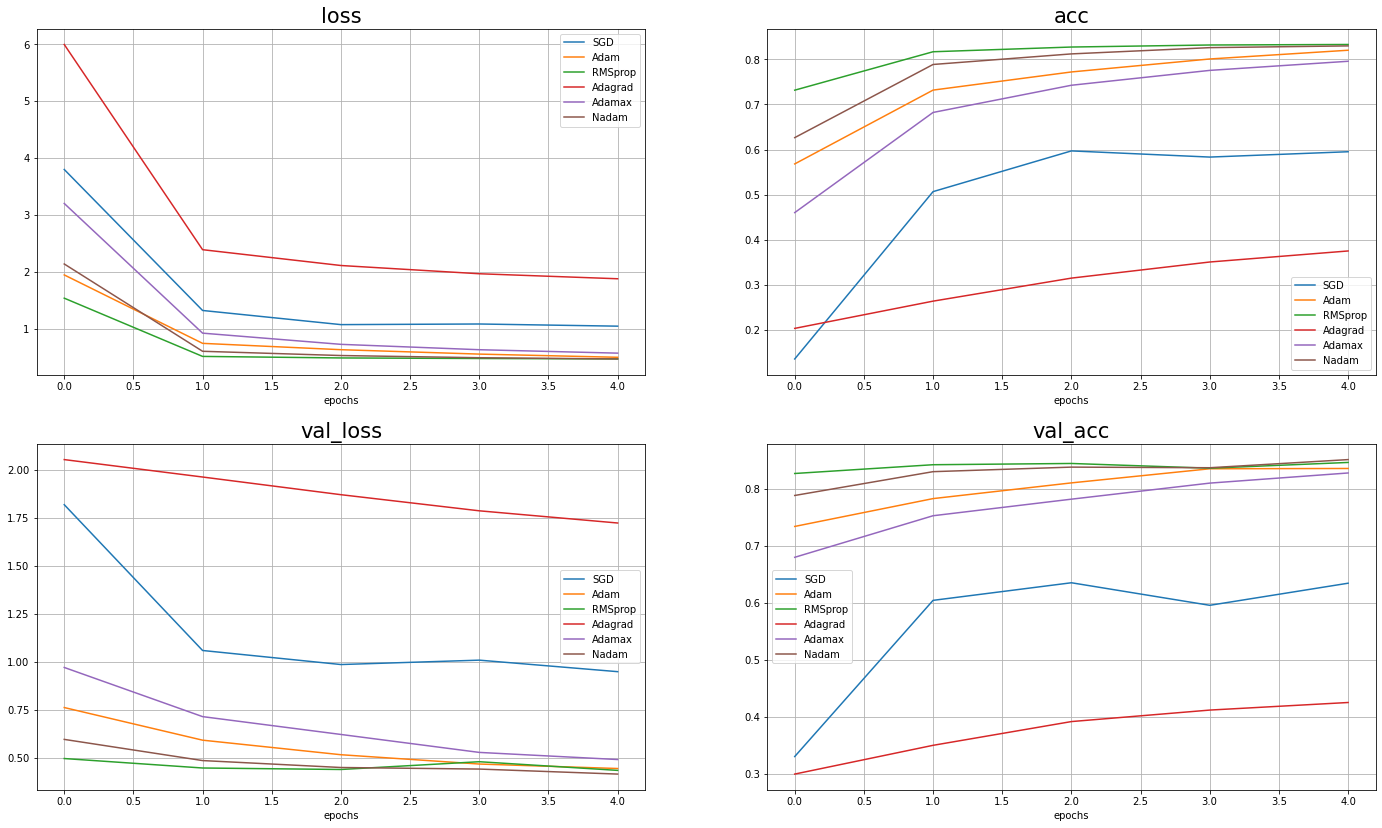

In [5]:
import matplotlib.pyplot as plt
indicators = ['loss', 'acc', 'val_loss', 'val_acc']
fig, axs = plt.subplots(2, 2, figsize=(24,14))
for ax, indicator in zip(axs.flatten(), indicators):
    ax.set_title(indicator, fontsize=21)
    ax.set_xlabel('epochs')
    ax.grid(True)
    for score in cnn_scores:
        score_dict, _, history = score
        ax.plot(history.history[indicator], label=score_dict['Optimizer'])
        ax.legend()

Observe that `Adagrad` seems to perform worse than the other optimizers, which improve their accuracy way faster (or are already way more accurate in the first epochs).
The overall trend of the curves suggests that the number of epochs chosen is enough and stability is reached for the best-performing optimizers.

### Performance table

We show here the table with the overall performance of the CNN for different optimizers. Note that, at its best, the network functions with circa 85% of accuracy.

In [6]:
import pandas as pd
cnn_dataframes = []
for score in cnn_scores:
    score_dict, _, _ = score
    df = pd.DataFrame.from_dict(score_dict, columns=[score_dict['Optimizer']], orient='index').drop('Optimizer')
    cnn_dataframes += [df]
aa = pd.concat(cnn_dataframes, axis=1)
display(aa)

,SGD,Adam,RMSprop,Adagrad,Adamax,Nadam
Loss,0.9473,0.4429,0.4332,1.7214,0.4897,0.4140
Accuracy,0.6342,0.8357,0.8463,0.4247,0.8278,0.8513


## Random Forest

In [7]:
config = {
    'n_estimators': 200,
    'criterion': 'entropy'
}

In [8]:
rf = RandomForest(keras.datasets.fashion_mnist, config)

In [9]:
%time rf_scores = rf.evaluate()

CPU times: user 2min 22s, sys: 197 ms, total: 2min 22s
Wall time: 2min 22s


## Comparison

In order to compare the performance of the two classfication methods, we need to define what is meant for good performance of a method.
Of course, a well-performing method is one that is accurate within the validation dataset and can, therefore, predict any new input with enough precision.
On the other hand, we would like such method to be able to run in a reasonable amount of time.

In [10]:
comparison_config_cnn = {
    'epochs': 5,
    'dropout': 0.2,
    'batch_size': 32,
    'optimizer': 'Nadam',
}

In [11]:
comparison_cnn = CNN(keras.datasets.fashion_mnist, comparison_config_cnn)

In [12]:
%time comparison_cnn_score = comparison_cnn.evaluate()

CPU times: user 4min 33s, sys: 3min 6s, total: 7min 39s
Wall time: 1min 58s


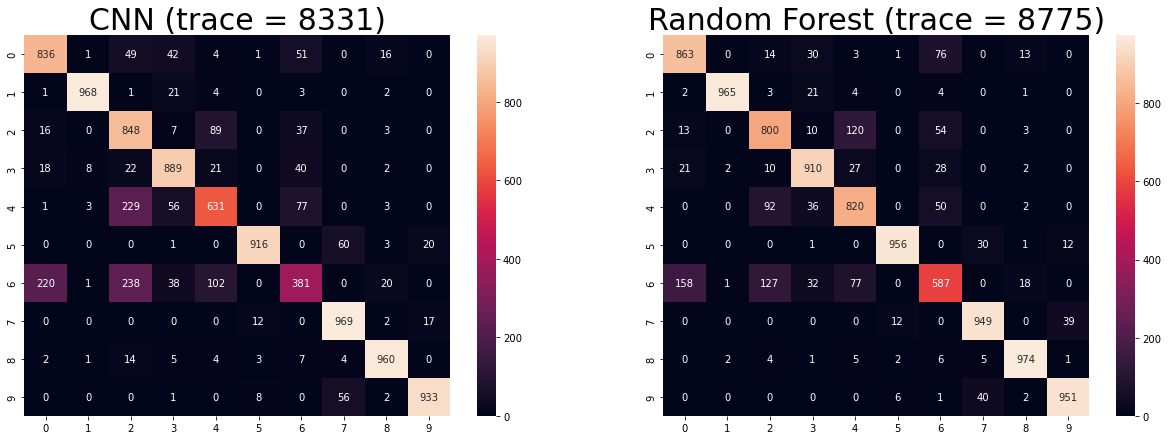

In [13]:
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(21, 7))
for ax, cm, title in zip(axs, (comparison_cnn_score[1], rf_scores[0]), ['CNN', 'Random Forest']):
    ax.set_title(title + ' (trace = ' + str(cm.trace()) + ')', size=30)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)

In [14]:
type(report)

NameError: name 'report' is not defined

In [ ]:
report

In [ ]:
import pandas as pd
df = pd.DataFrame(report).transpose()

In [ ]:
df